<a href="https://colab.research.google.com/github/DrSubbiah/1.Bayesian-Inference/blob/master/9.1_BinomialProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="darkblue">Binary Data Model

In [ ]:
import numpy as np
import pandas as pd
import statistics as stat
import scipy
import pystan

In [ ]:
#For plots
import arviz as az
import matplotlib.pyplot as plt

#<font color="darkblue"> Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Data Sets/TelcoCustomerChurn.csv"
custchur_da = pd.read_csv(path)

In [ ]:
custchur_da.head()

In [ ]:
custchur_da=custchur_da.assign(churn_c=lambda x:x['Churn'].apply(lambda y: 1 if y=="Yes" else 0))

In [ ]:
print(custchur_da.dtypes)

In [ ]:
custchur_da.sample(n=5, frac=None, replace=False, weights=None, random_state=None, axis=0)

# <font color="darkblue"> Model 1. Binomial - Beta Model

## logit transformation is also included

Also the input is based on the two models

- Data: Binomial

- Prior: Beta

# Input - data and values for prior parameters a and b

In [ ]:
custchur_data = {
             'n': len(custchur_da),
             'y': len(custchur_da.loc[custchur_da['churn_c'] == '1']),
             'a':1,
             'b':1,
            }
print(custchur_data)

{'n': 462, 'y': 160, 'a': 1, 'b': 1}


In [ ]:
custchur_code1 = """
data {
    real<lower=0> a;
    real<lower=0> b;
    int<lower=0> n;
    int<lower=0> y;
}

parameters {
    real<lower=0, upper=1> p;
}

transformed parameters {
  real theta;
  theta=logit(p);
}

model {
      y ~ binomial(n, p);
      p ~ beta(a, b);
}
"""
# posterior
posterior1 = pystan.StanModel(model_code=custchur_code1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_725616b82292790061373c1b3775c9b7 NOW.


In [ ]:
fit_model1= posterior1.sampling(data=custchur_data,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
custchur_data_op=az.from_pystan(posterior=fit_model1)#,observed_data=['y'])
custchur_data_op

Inference data with groups:
	> posterior
	> sample_stats

INFO:numba.core.transforms:finding looplift candidates


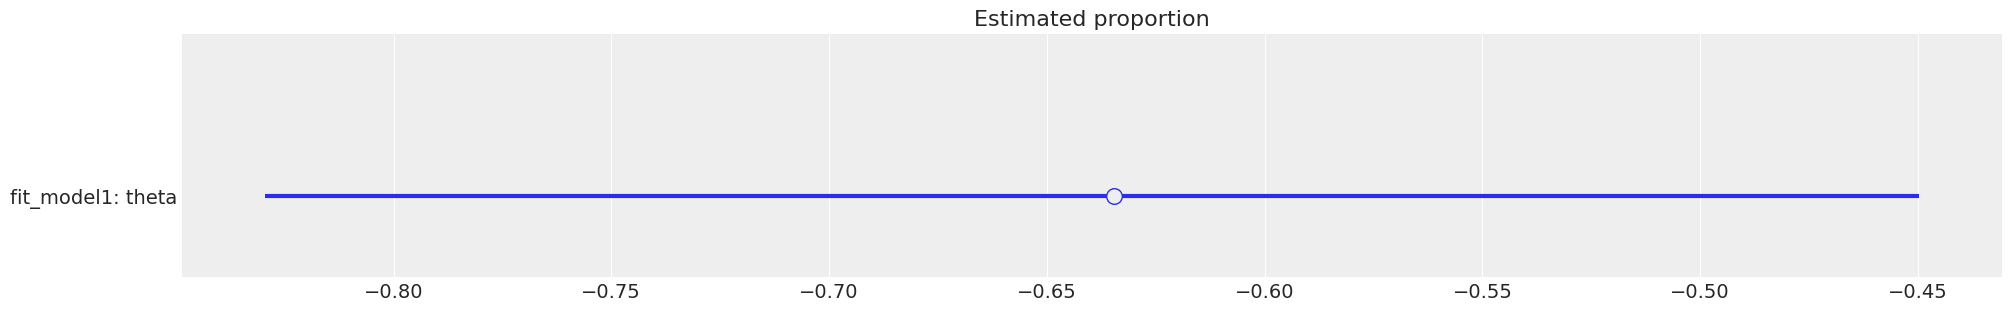

In [ ]:
import matplotlib.pyplot as pylt

az.style.use("arviz-darkgrid")

# centered_data = az.load_arviz_data("centered_eight")
# non_centered_data = az.load_arviz_data("non_centered_eight")
axes = az.plot_forest([custchur_data_op], model_names=["fit_model1"],var_names=['theta'],combined=True,
                      quartiles=False,hdi_prob=0.95,figsize=(20, 3),markersize=15)
axes[0].set_title("Estimated proportion")

plt.show()

In [ ]:
centered_data = az.load_arviz_data("centered_eight")
centered_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> observed_data

# <font color="darkorange">Pystan Summary - Information about Model and Metrics

In [ ]:
fit_model1_summary=fit_model1.stansummary(pars=["p","theta"], probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=4)
print(fit_model1_summary)

# <font color="darkorange"> Condensed Summary Report

In [ ]:
summ_mod1=az.summary(fit_model1,round_to=3,hdi_prob=0.95)
summ_mod1

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.347,0.022,0.304,0.389,0.000,0.000,7249.863,7066.032,1.001
theta,-0.636,0.097,-0.830,-0.450,0.001,0.001,7249.863,7066.032,1.001


# <font color="darkgreen">Inverse Transformation

In this model logit transform has been used to find the log of odds for success.

Appropriate Inverse transformation function can be used to find the probability from logit

## logit from probability (p)

$$\mathrm{y=logit}(p) = \log(\frac{p}{1-p})$$

## Inverse logit - expit(y)

$$\mathrm{p=expit}(y) = \frac{e^p}{1+e^p}=\frac{1}{1+e^{-p}}$$

In [ ]:
theta_op=summ_mod1.iloc[1,[0,2,3]]
scipy.special.expit(theta_op)

#<font color="darkorange"> MCMC convergence Diagnostics - Plots

In [ ]:
az.plot_trace(fit_model1, compact=False,legend=True)
plt.show()

# <font color="darkorange">Histogram, Density plot from the posterior1 for the QoI

In [ ]:
# QoI "p"
az.plot_dist(fit_model1['p'],quantiles=[.25, .5, .75],kind="hist",figsize=(20, 6))
plt.show()

In [ ]:
#QoI "theta=logit(p)"
az.plot_dist(fit_model1['theta'],quantiles=[0.25, 0.5, 0.75],kind="kde",figsize=(20, 6))
plt.show()

# <font color="darkgreen">Posterior Probabilities

1. Obtain the generated samples at each iteration

  - Use pystan function *extract*

2. Compute the required probabilites as a ratio of favourable points (desired condtion) to the total number of samples

In [ ]:
zz=pd.DataFrame(fit_model1.extract())

In [ ]:
pr1=np.count_nonzero(zz["p"]> 0.3, axis=0)/len(zz)

pr2=np.count_nonzero(zz["p"]< 0.345, axis=0)/len(zz)

pr3=np.count_nonzero((zz["p"]>0.3) & (zz["p"] < 0.345))/len(zz)

print(round(pr1,4),round(pr2,4),round(pr3,4))

# <font color="darkblue"> Model 2. Binomial - Beta Model

## Prior is a Normal (Gaussian) distribution truncated to the range (0,1)

Stan format for a Normal distribution in a finite interval (L, U)

$$\mathrm{Normal}(\mu, \sigma) T[L,U]$$

In [ ]:
# Binomial model with Halfnormal prior
custchur_code2 = """
data {
    real<lower=0> a;
    real<lower=0> b;
    int<lower=0> n;
    int<lower=0> y;
}

parameters {
    real<lower=0, upper=1> p;
}
model {
    y ~ binomial(n, p);
    p ~ normal(a, b)T[0,1];
}

"""
# posterior
posterior2 = pystan.StanModel(model_code=custchur_code2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_29b76410d843c7652b2c7394eaf66013 NOW.


# <font color="darkgreen">Truncated Normal parameters

$\mu = a$ and $\sigma =b$

$a = 0.5$ and  $b = 1$

In [ ]:
custchur_data_T = {
             'n': len(custchur_da),
             'y': len(custchur_da.loc[custchur_da['chd'] == 'Yes']),
             'a':0.5,
             'b':1,
            }
print(custchur_data_T)

{'n': 462, 'y': 160, 'a': 0.5, 'b': 1}


In [ ]:
fit_model2= posterior2.sampling(data=custchur_data_T,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
summ_mod2=az.summary(fit_model2,round_to=3,hdi_prob=0.95)
summ_mod2

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.347,0.022,0.303,0.389,0.0,0.0,7524.42,7155.76,1.001


In [ ]:
az.plot_trace(fit_model2,compact=False, legend=True)
plt.show()

In [ ]:
# QoI "p"
az.plot_dist(fit_model2['p'],quantiles=[.25, .5, .75],kind="hist",figsize=(20, 6))
plt.show()

# <font color="darkblue"> Model 3. Binomial - Beta Model

## Same as Model 1, but logit (p) is estimated from the generated quantities but not as a parameter (transformed)


In [ ]:
custchur_code3 = """
data {
    real<lower=0> a;
    real<lower=0> b;
    int<lower=0> n;
    int<lower=0> y;
}

parameters {
    real<lower=0, upper=1> p;
}

model {
      y ~ binomial(n, p);
      p ~ beta(a, b);
}

generated quantities{
  real theta;
  theta=logit(p);
}
"""
# posterior
posterior3 = pystan.StanModel(model_code=custchur_code3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6a391ea69b3022ab64c0f4a542467972 NOW.


In [ ]:
fit_model3= posterior3.sampling(data=custchur_data,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
summ_mod3=az.summary(fit_model3,round_to=3,hdi_prob=0.95)
summ_mod3

In [ ]:
az.plot_trace(fit_model2,compact=False, legend=True)
plt.show()

In [ ]:
# QoI "p"
az.plot_dist(fit_model2['p'],quantiles=[.25, .5, .75],kind="hist",figsize=(20, 6))
plt.show()

# Binomial Regression without predictor



In [ ]:
custchur_fit_code0 = """
data {
    real<lower=0> a;
    real<lower=0> b;
    int<lower=0> k;

    int y[k];
}

parameters {
  real b0;
 }

model {
     y ~ bernoulli_logit(b0);
     b0 ~ normal(a, b);
}
"""


# Posterior
posterior0 = pystan.StanModel(model_code=custchur_fit_code0)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3927b8f5c85f6b45d8fbd9f759a9506f NOW.


In [ ]:
# Input - data and values for prior parameters a and b

n=len(custchur_da)
y1=custchur_da['chd_c']
#y2=print((y1.to_numpy()))
custchur_data0 = {'k':n,
             'y':y1,
             'a':0,
             'b':1,
             }


In [ ]:
custchur_fit0= posterior0.sampling(data=custchur_data0,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

print(custchur_fit0.stansummary(pars=["b0"], probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=4))

In [ ]:
summ_fit0=az.summary(custchur_fit0,round_to=3,hdi_prob=0.95)
summ_fit0

In [ ]:
az.plot_trace(custchur_fit0,compact=False, legend=True)
plt.show()

In [ ]:
# QoI "p"
az.plot_dist(custchur_fit0['b0'],quantiles=[.25, .5, .75],kind="hist",figsize=(20, 6))
plt.show()

# Probit Link

In [ ]:
custchur_fit_code00 = """
data {
    real<lower=0> a;
    real<lower=0> b;
    int<lower=0> k;

    int y[k];
}

parameters {
  real b0;
 }

model {
     y ~ bernoulli(Phi(b0));
     b0 ~ normal(a, b);
}
"""


# Posterior
posterior00 = pystan.StanModel(model_code=custchur_fit_code00)


In [ ]:
# Input - data and values for prior parameters a and b

n=len(custchur_da)
y1=custchur_da['chd_c']
#y2=print((y1.to_numpy()))
custchur_data0 = {'k':n,
             'y':y1,
             'a':0,
             'b':1,
             }


In [ ]:
custchur_fit00= posterior00.sampling(data=custchur_data0,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
summ_fit00=az.summary(custchur_fit00,round_to=3,hdi_prob=0.95)
summ_fit00

In [ ]:
az.plot_trace(custchur_fit00,compact=False, legend=True)
plt.show()

In [ ]:
# QoI "p"
az.plot_dist(custchur_fit00['b0'],quantiles=[.25, .5, .75],kind="hist",figsize=(20, 6))
plt.show()

# Binary Logit Model with One Binary Predictor

In [ ]:
custchur_fit_code1 = """
data {
int<lower=0> N;
int<lower=0,upper=1> y[N];
vector[N] x1;
real a0;
real<lower=0> b0;
real a1;
real<lower=0> b1;
}

parameters {
real beta0;
real beta1;
}
model {
y ~ bernoulli_logit(beta0 + beta1 * x1);

beta0 ~ normal(a0,b0);
beta1 ~ normal(a1,b1);
}
"""


# Posterior
posterior_fit1 = pystan.StanModel(model_code=custchur_fit_code1)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d948fc6faac4534da2d95b167f81f54b NOW.


In [ ]:
custchur_da=custchur_da.assign(gender_c=lambda x:x['gender'].apply(lambda y: 1 if y=="Male" else 0))
#custchur_da['famhist_c'] = custchur_da['famhist_c'].astype('category')

In [ ]:
# Input - data and values for prior parameters a and b

n=len(custchur_da)
y1=custchur_da['churn_c']
x=custchur_da['gender_c']
#y2=print((y1.to_numpy()))
custchur_data1 = {'N':n,
             'y':y1,
             'x1':x,
             'a0':0,
             'b0':100,
             'a1':0,
             'b1':100
            }
custchur_data1

In [ ]:
y2=custchur_da['churn_c']
x2=custchur_da['gender_c']
pd.crosstab(x2, y2)

In [ ]:
custchur_fit1= posterior_fit1.sampling(data=custchur_data1,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=10,verbose=True,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

# print(custchur_fit1.stansummary(pars=["b0"], probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=4))

In [ ]:
custchur_fit1_op=az.from_pystan(posterior=custchur_fit1)
custchur_fit1_op

Inference data with groups:
	> posterior
	> sample_stats

In [ ]:
import matplotlib.pyplot as pylt
az.style.use("arviz-darkgrid")
axes= az.plot_forest([custchur_fit1_op], var_names=['b1'],combined=True,
                      quartiles=False,hdi_prob=0.95,figsize=(20, 5),markersize=15)
pylt.vlines(0,ymin=0, ymax=8,color="black", linestyle="--")

axes[0].set_title("Estimated proportion")
pylt.show()

In [ ]:
summ_fit1=az.summary(custchur_fit1,round_to=3,hdi_prob=0.95)
summ_fit1

Shape validation failed: input_shape: (1, 700), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,-0.998,0.038,-1.076,-0.928,0.002,0.001,619.431,532.100,NaN
b1,-0.037,0.052,-0.133,0.069,0.002,0.001,654.377,583.457,NaN


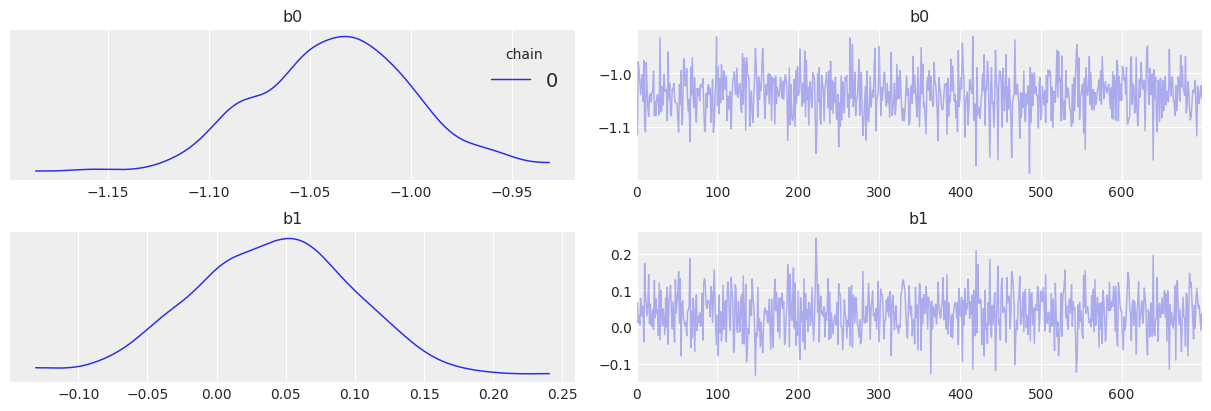

In [ ]:
az.plot_trace(custchur_fit1,compact=False, legend=True)
plt.show()

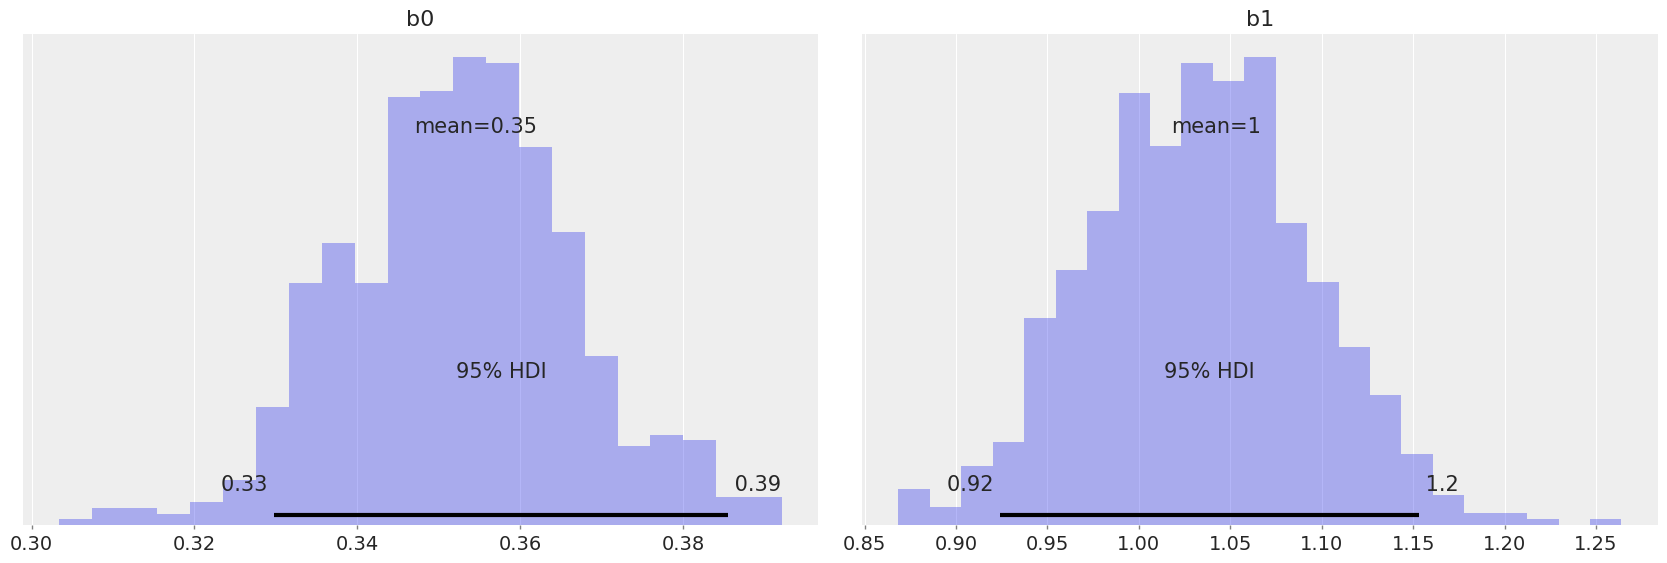

In [ ]:
az.plot_posterior(custchur_fit1,
            var_names=['b0', 'b1'],
            transform=np.exp, #scipy.special.expit,
            hdi_prob=0.95,
            kind="hist")
plt.show()

In [ ]:
np.exp(0.151)

# <font color="darkred"> Predictors in Matrix Form

In [ ]:
custchur_fit_code2 = """
data {
int<lower=0> K;
int<lower=0> N;
int<lower=0,upper=1> y[N];
matrix[N,K] X;
real a0;
real<lower=0> b0;
real a1;
real<lower=0> b1;
}

parameters {
real alpha;
vector[K] beta;
}

model {
y ~ bernoulli_logit(alpha+X*beta);

alpha ~ cauchy(a0,b0);
for(i in 1:K)
    beta[i] ~ student_t(1, a1, b1);
}
"""


# Posterior
posterior_fit2 = pystan.StanModel(model_code=custchur_fit_code2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_017ae8c21c6e3b00c534236df6fab803 NOW.


In [ ]:
# Input - data and values for prior parameters a and b

n=len(custchur_da)
y1=custchur_da['churn_c']
x=np.transpose(np.asmatrix(custchur_da['gender_c']))
#y2=print((y1.to_numpy()))
custchur_data2 = {'N':n,
                  'K':1,
             'y':y1,
             'X':x,
             'a0':0,
             'b0':10,
             'a1':0,
             'b1':0.03
            }
custchur_data2

In [ ]:
custchur_fit2= posterior_fit2.sampling(data=custchur_data2,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=10,verbose=True,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
print(custchur_fit2.stansummary(probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=4))

Inference for Stan model: anon_model_017ae8c21c6e3b00c534236df6fab803.
4 chains, each with iter=10000; warmup=3000; thin=10; 
post-warmup draws per chain=700, total post-warmup draws=2800.

            mean se_mean     sd     2.5%      25%      50%      75%    97.5%  n_eff   Rhat
alpha     -1.009  0.0006  0.032   -1.075   -1.029   -1.009   -0.988   -0.948   2688 0.9996
beta[1]   -0.014  0.0007 0.0341   -0.093   -0.032   -0.011   0.0061   0.0502   2668 1.0004
lp__    -4.076e3  0.0214 1.1471 -4.079e3 -4.077e3 -4.076e3 -4.075e3 -4.075e3   2864 1.0001

Samples were drawn using NUTS at Tue Jan 11 08:56:57 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
custchur_fit2_op=az.from_pystan(posterior=custchur_fit2)
custchur_fit2_op

In [ ]:
import matplotlib.pyplot as pylt
az.style.use("arviz-darkgrid")
axes= az.plot_forest([custchur_fit1_op], var_names=['b1'],combined=True,
                      quartiles=False,hdi_prob=0.95,figsize=(20, 5),markersize=15)
pylt.vlines(0,ymin=0, ymax=8,color="black", linestyle="--")

axes[0].set_title("Estimated proportion")
pylt.show()

In [ ]:
summ_fit2=az.summary(custchur_fit2,round_to=3,hdi_prob=0.95)
summ_fit2

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.009,0.032,-1.071,-0.944,0.001,0.0,2691.946,2573.929,1.001
beta[0],-0.015,0.034,-0.085,0.055,0.001,0.0,2701.644,2811.027,1.001


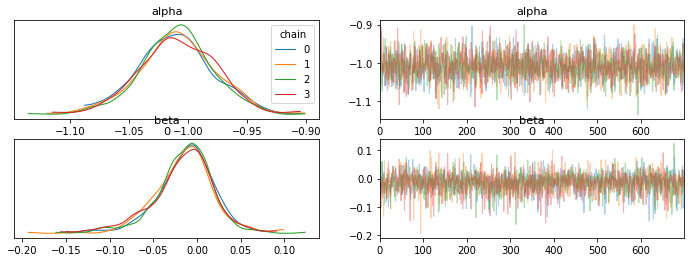

In [ ]:
az.plot_trace(custchur_fit2,compact=False, legend=True)
plt.show()